# Kafka and Spark Streaming
> Installing Kafka and Spark streaming in colab and streaming Twitter dataset

- categories: [spark, pyspark, kafka, Twitter]
- image:

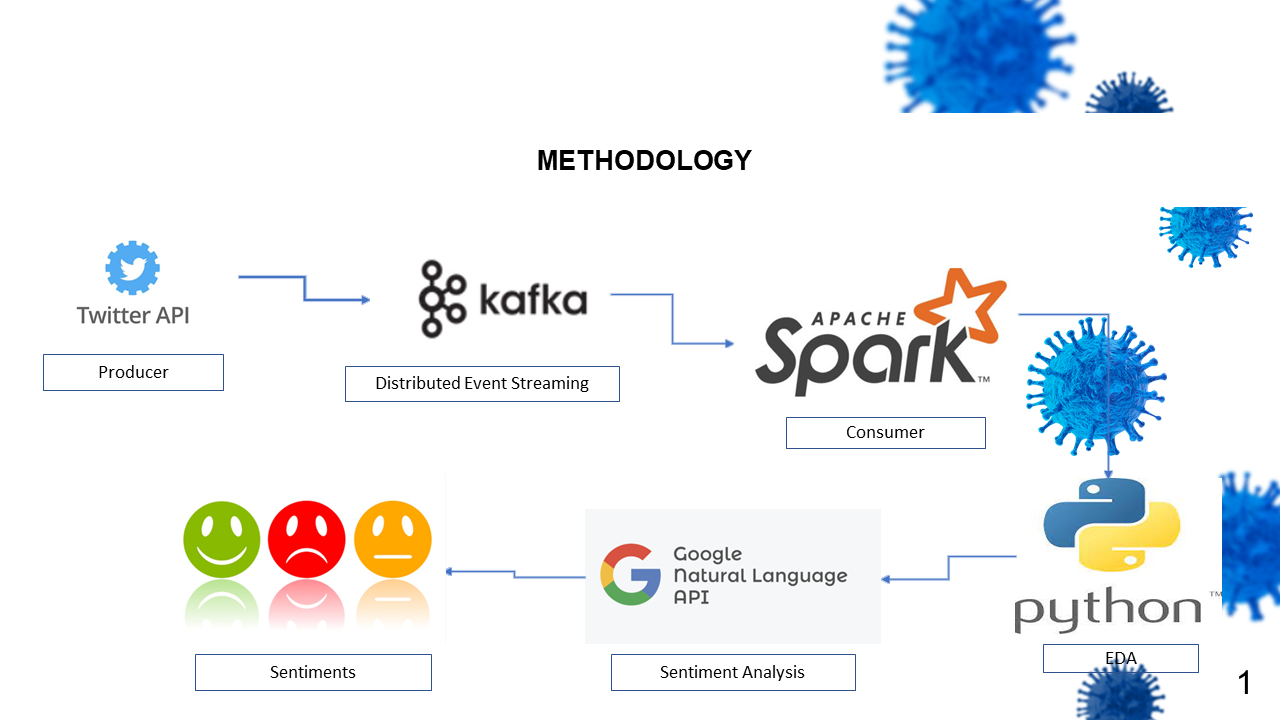

There are several benefits of implementing Spark-Kafka integration. You can ensure minimum data loss through Spark Streaming while saving all the received Kafka data synchronously for an easy recovery. Users can read messages from a single topic or multiple Kafka topics. 

Along with this level of flexibility you can also access high scalability, throughput and fault-tolerance and a range of other benefits by using Spark and Kafka in tandem. This integration can be understood with a data pipeline that functions in the methodology shown below:

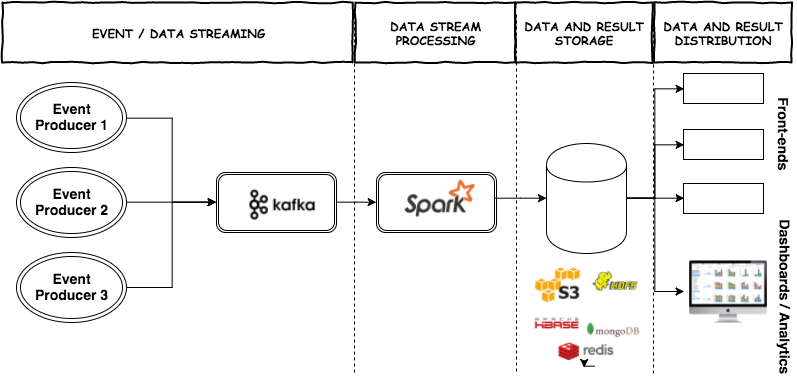

In [1]:
!pip install kafka-python

# **Import packages**

In [2]:
import os
from datetime import datetime
import time
import threading
import json
from kafka import KafkaProducer
from kafka.errors import KafkaError
import pandas as pd
from sklearn.model_selection import train_test_split

## Download and setup Kafka and Zookeeper instances

For demo purposes, the following instances are setup locally:

- Kafka (Brokers: 127.0.0.1:9092)
- Zookeeper (Node: 127.0.0.1:2181)


In [3]:
!curl -sSOL https://downloads.apache.org/kafka/2.7.2/kafka_2.13-2.7.2.tgz
!tar -xzf kafka_2.13-2.7.2.tgz

Using the default configurations (provided by Apache Kafka) for spinning up the instances.

In [1]:
!./kafka_2.13-2.7.2/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-2.7.2/config/zookeeper.properties
!./kafka_2.13-2.7.2/bin/kafka-server-start.sh -daemon ./kafka_2.13-2.7.2/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


Once the instances are started as daemon processes, grep for `kafka` in the processes list. The two java processes correspond to zookeeper and the kafka instances.

In [5]:
!ps -ef | grep kafka

root         500       1  0 17:36 ?        00:00:04 java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -XX:MaxInlineLevel=15 -Djava.awt.headless=true -Xlog:gc*:file=/content/kafka_2.13-2.7.2/bin/../logs/zookeeper-gc.log:time,tags:filecount=10,filesize=100M -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/content/kafka_2.13-2.7.2/bin/../logs -Dlog4j.configuration=file:./kafka_2.13-2.7.2/bin/../config/log4j.properties -cp /content/kafka_2.13-2.7.2/bin/../libs/activation-1.1.1.jar:/content/kafka_2.13-2.7.2/bin/../libs/aopalliance-repackaged-2.6.1.jar:/content/kafka_2.13-2.7.2/bin/../libs/argparse4j-0.7.0.jar:/content/kafka_2.13-2.7.2/bin/../libs/audience-annotations-0.5.0.jar:/content/kafka_2.13-2.7.2/bin/../libs/commons-cli-1.4.jar:/content/kafka_2.13-2.7.2/bin/../libs/commons-lang3-3.8.1.jar:/content/kafka_2.13

**Create the kafka topics with the following specs:**

- twitter-train: partitions=1, replication-factor=1 
- twitter-test: partitions=2, replication-factor=1 

In [24]:
!./kafka_2.13-2.7.2/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic twitter-train2
!./kafka_2.13-2.7.2/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 2 --topic twitter-test2


Created topic twitter-train2.
Created topic twitter-test2.


**Describe the topic for details on the configuration**




In [3]:
!./kafka_2.13-2.7.2/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic twitter-train
!./kafka_2.13-2.7.2/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic twitter-test

Topic: twitter-train	PartitionCount: 1	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: twitter-train	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
Topic: twitter-test	PartitionCount: 2	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: twitter-test	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
	Topic: twitter-test	Partition: 1	Leader: 0	Replicas: 0	Isr: 0


**Initilizing Kafka Zookeeper**

In [36]:
!kafka_2.13-2.7.2/bin/kafka-topics.sh --create --zookeeper localhost:2181 --replication-factor 1 --partitions 1 --topic twitter-train3
!kafka_2.13-2.7.2/bin/kafka-topics.sh --create --zookeeper localhost:2181 --replication-factor 1 --partitions 2 --topic twitter-test3

Created topic twitter-train3.
Created topic twitter-test3.


In [38]:
!kafka_2.13-2.7.2/bin/kafka-console-producer.sh --broker-list localhost:9092 --topic twitter-train3
!kafka_2.13-2.7.2/bin/kafka-console-producer.sh --broker-list localhost:9092 --topic twitter-test3

>hello
>world
>how areyou
>jbkjb'df
>>

The replication factor 1 indicates that the data is not being replicated. This is due to the presence of a single broker in our kafka setup.
In production systems, the number of bootstrap servers can be in the range of 100's of nodes. That is where the fault-tolerance using replication comes into picture.

Please refer to the [docs](https://kafka.apache.org/documentation/#replication) for more details.


## Twitter Dataset

Kafka being an event streaming platform, enables  data from various sources to be written into it. For instance:

- Web traffic logs
- Astronomical measurements
- IoT sensor data
- Product reviews and many more.


## Explore the dataset

In [8]:
tweets = pd.read_csv('/content/tweetsfinalsentimentanalysis.csv')
tweets.head()

,tweets,Sentiments
0,What Flying Flock wrong with guys terrified yo...,2
1,general public think covid doesn affect them m...,1
2,Another reason vaxxed ease immense pressure aw...,1
3,Officially triple vaxxed club Body time your t...,1
4,CovidVaccine vaccine CoronavirusUpdates CovidV...,0


In [9]:
# Number of datapoints and columns
len(tweets), len(tweets.columns)

(2031, 2)

## Split the dataset


In [10]:
train_df, test_df = train_test_split(tweets, test_size=0.4, shuffle=True)
print("Number of training samples: ",len(train_df))
print("Number of testing sample: ",len(test_df))

x_train_df = train_df.drop(["Sentiments"], axis=1)
y_train_df = train_df["Sentiments"]

x_test_df = test_df.drop(["Sentiments"], axis=1)
y_test_df = test_df["Sentiments"]

# The labels are set as the kafka message keys so as to store data
# in multiple-partitions. Thus, enabling efficient data retrieval
# using the consumer groups.
x_train = list(filter(None, x_train_df.to_csv(index=False).split("\n")[1:]))
y_train = list(filter(None, y_train_df.to_csv(index=False).split("\n")[1:]))

x_test = list(filter(None, x_test_df.to_csv(index=False).split("\n")[1:]))
y_test = list(filter(None, y_test_df.to_csv(index=False).split("\n")[1:]))

Number of training samples:  1218
Number of testing sample:  813


In [11]:
NUM_COLUMNS = len(train_df.columns)
len(x_train), len(y_train), len(x_test), len(y_test)

(1218, 1218, 813, 813)

## Store the train and test data in kafka

Storing the data in kafka simulates an environment for continuous remote data retrieval for training and inference purposes.

In [12]:
def error_callback(exc):
    raise Exception('Error while sendig data to kafka: {0}'.format(str(exc)))

def write_to_kafka(topic_name, items):
  count=0
  producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'])
  for message, key in items:
    producer.send(topic_name, key=key.encode('utf-8'), value=message.encode('utf-8')).add_errback(error_callback)
    count+=1
  producer.flush()
  print("Wrote {0} messages into topic: {1}".format(count, topic_name))

In [13]:
write_to_kafka("twitter-train1", zip(x_train, y_train))
write_to_kafka("twitter-test1", zip(x_test, y_test))

Wrote 1218 messages into topic: twitter-train1
Wrote 813 messages into topic: twitter-test1


In [4]:
 ! /content/kafka_2.13-2.7.2/bin/kafka-console-consumer.sh \
 --bootstrap-server localhost:9092 \
 --topic twitter-train1 \
 --from-beginning

This flat false tantamount dangerous misinformation https QhkDdotmoF
date with omicron bill Yeah know https vnYsoLj
Christmas CovidVaccine COVID https DKFl VjPmQ
Omicron variant dominant Omicron OmicronVariant OmicronVirus Omicronsymptoms COVID VarianteOmicron variante VariantOmicron coronavirus variantesudafricana https Ztwr
CovidVaccine COVID COVID covidvariant OmicronVariant Omicron OmicronVirus Covid COVID https gtXUFFr
Time tell Long Island restaurants check vaccination status Those little restrictions Waiting until feel need impose lockdowns ahead this covidvariant CovidVaccine NYS
have sense will postpone Elections from yatras rallies have already started UPElection OmicronVariant Omicronindia
know this omicron shit deep cause caught absolutely nowhere except grocery store
least Twitter admits CovidVaccine Politics about health safety anymore about Politics efficacy weak safe vaccine just symbol obedience this point https WHDo
BREAKING Omicron stacking national viral blizzard ac

## Spark Streaming

Creating Spark Enivronment

In [15]:
!apt update

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [16]:
!java -version

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [17]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.8-bin-hadoop2.7.tgz
!pip install findspark

--2021-12-21 18:03:33--  https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.214.104, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235899716 (225M) [application/x-gzip]
Saving to: ‘spark-2.4.8-bin-hadoop2.7.tgz.2’

spark-2.4.8-bin-had 100%[===================>] 224.97M  18.2MB/s    in 14s     

2021-12-21 18:03:47 (16.0 MB/s) - ‘spark-2.4.8-bin-hadoop2.7.tgz.2’ saved [235899716/235899716]

spark-2.4.8-bin-hadoop2.7/
spark-2.4.8-bin-hadoop2.7/LICENSE
spark-2.4.8-bin-hadoop2.7/NOTICE
spark-2.4.8-bin-hadoop2.7/R/
spark-2.4.8-bin-hadoop2.7/R/lib/
spark-2.4.8-bin-hadoop2.7/R/lib/SparkR/
spark-2.4.8-bin-hadoop2.7/R/lib/SparkR/DESCRIPTION
spark-2.4.8-bin-hadoop2.7/R/lib/SparkR/INDEX
spark-2.4.8-bin-hadoop2.7/R/lib/SparkR/Meta/
spark-2.4.8-bin-hadoop2.7/R/lib/SparkR/Me

In [18]:
!wget "https://repo1.maven.org/maven2/org/apache/spark/spark-streaming-kafka-0-8-assembly_2.11/2.4.8/spark-streaming-kafka-0-8-assembly_2.11-2.4.8.jar"

--2021-12-21 18:03:54--  https://repo1.maven.org/maven2/org/apache/spark/spark-streaming-kafka-0-8-assembly_2.11/2.4.8/spark-streaming-kafka-0-8-assembly_2.11-2.4.8.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12002039 (11M) [application/java-archive]
Saving to: ‘spark-streaming-kafka-0-8-assembly_2.11-2.4.8.jar.2’

spark-streaming-kaf 100%[===================>]  11.45M  --.-KB/s    in 0.09s   

2021-12-21 18:03:54 (123 MB/s) - ‘spark-streaming-kafka-0-8-assembly_2.11-2.4.8.jar.2’ saved [12002039/12002039]



In [19]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /content/spark-streaming-kafka-0-8-assembly_2.11-2.4.8.jar pyspark-shell'

In [20]:
import findspark
findspark.init()

In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import Normalizer, StandardScaler
import random
import pyspark
import sys
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from uuid import uuid1
import time

kafka_topic_name = "twitter-train1"
kafka_bootstrap_servers = '127.0.0.1:9092'

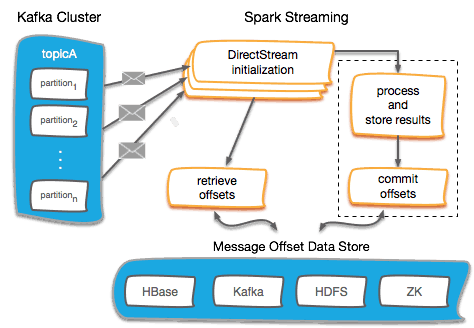

In [22]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 18:03:54


In [43]:
sc = pyspark.SparkContext()
ssc = StreamingContext(sc,5)

kafka_topic_name = "twitter-train1"
kafka_bootstrap_servers = 'localhost:9092'

kvs = KafkaUtils.createStream(ssc, kafka_bootstrap_servers, 'spark-streaming',{'twitter-train3':1})
kvs = KafkaUtils.createDirectStream(ssc, [kafka_topic_name], {"metadata.broker.list": kafka_bootstrap_servers})
kvs = KafkaUtils.createDirectStream(ssc, [kafka_topic_name], {
                       'bootstrap.servers':kafka_bootstrap_servers,
                        'group.id':'test-group',
                        'auto.offset.reset':'largest'})

lines = kvs.map(lambda x: x[1])
counts = lines.flatMap(lambda line: line.split(' '))
counts = lines.flatMap(lambda line: line.split(' ')).map(lambda word: (word, 1)).reduceByKey(lambda a, b: a+b)
counts.pprint()
ssc.start()
# stream will run for 50 sec
ssc.awaitTerminationOrTimeout(100)
ssc.stop()
sc.stop()

-------------------------------------------
Time: 2021-12-21 18:42:15
-------------------------------------------

-------------------------------------------
Time: 2021-12-21 18:42:20
-------------------------------------------

-------------------------------------------
Time: 2021-12-21 18:42:25
-------------------------------------------

-------------------------------------------
Time: 2021-12-21 18:42:30
-------------------------------------------

-------------------------------------------
Time: 2021-12-21 18:42:35
-------------------------------------------

-------------------------------------------
Time: 2021-12-21 18:42:40
-------------------------------------------

-------------------------------------------
Time: 2021-12-21 18:42:45
-------------------------------------------

-------------------------------------------
Time: 2021-12-21 18:42:50
-------------------------------------------

-------------------------------------------
Time: 2021-12-21 18:42:55
----------

## Further exploration
- https://towardsdatascience.com/enabling-streaming-data-with-spark-structured-streaming-and-kafka-93ce91e5b435
